In [8]:
import sys
import os
from itertools import chain
from collections import defaultdict
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('precision', 3)
import gseapy as gp
import goatools
import numpy as np

obodag = goatools.obo_parser.GODag('go-basic.obo')
sys.path.insert(0, "/home/gstupp/projects/metaproteomics")
from metaproteomics import utils
#from metaproteomics.analysis import build_loci

BASE = '../out/'

load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2017-03-16) 48,478 GO Terms


In [26]:
def get_all_children(go_id):
    children = set([x.id for x in obodag.get(go_id).children])
    new_children = children
    while True:
        new_children = set(chain(*[[x.id for x in obodag.get(y).children] for y in new_children]))
        if not new_children:
            break
        children.update(new_children)
    return children
len(get_all_children('GO:0006928'))

393

In [126]:
topgo = {'GO:0006928', 'GO:0051179', 'GO:0006807', 'GO:0005975', 'GO:0019222', 'GO:0051186'}
topgo_children = {k:get_all_children(k) for k in topgo}
group_names = {x:"{} ({})".format(obodag.get(x).name, obodag.get(x).id) for x in topgo}
group_names[None] = "None"
group_names["multiple"] = "multiple"
group_names

{'GO:0006807': 'nitrogen compound metabolic process (GO:0006807)',
 None: 'None',
 'GO:0051179': 'localization (GO:0051179)',
 'GO:0051186': 'cofactor metabolic process (GO:0051186)',
 'multiple': 'multiple',
 'GO:0005975': 'carbohydrate metabolic process (GO:0005975)',
 'GO:0006928': 'movement of cell or subcellular component (GO:0006928)',
 'GO:0019222': 'regulation of metabolic process (GO:0019222)'}

In [127]:
group_colors = {k:c for k,c in zip(topgo, ['lightcoral', 'darkorange', 'darkgoldenrod', 
                                           'lawngreen', 'mediumseagreen', 'dodgerblue'])}
group_colors[None] = 'k'
group_colors['multiple'] = 'deeppink'
color_group = {v:k for k,v in group_colors.items()}
group_colors

{'GO:0006807': 'lightcoral',
 None: 'k',
 'GO:0051179': 'lawngreen',
 'GO:0051186': 'mediumseagreen',
 'multiple': 'deeppink',
 'GO:0005975': 'dodgerblue',
 'GO:0006928': 'darkorange',
 'GO:0019222': 'darkgoldenrod'}

In [128]:
def get_go_group(go):
    if not isinstance(go, str):
        return None
    membership = {k:any([x in v for x in go.split("|")]) for k,v in topgo_children.items()}
    if list(membership.values()).count(True)>1:
        group = "multiple"
    elif list(membership.values()).count(True)==1:
        group = [k for k,v in membership.items() if v][0]
    else:
        group = None
    return group
row = 5
get_go_group(df.iloc[row].go)

'GO:0006807'

In [129]:
df = pd.read_csv(os.path.join(BASE,"RT_control_results_named_annot.csv"), index_col=0)
df['-logp'] = -1*np.log(df.padj)
df['group'] = df.go.apply(get_go_group)
df['color'] = df.group.apply(group_colors.get)
df_sig = df[(df.padj<=0.2) & (abs(df.log2FoldChange) >= 1)]
df_insig = df[~((df.padj<=0.2) & (abs(df.log2FoldChange) >= 1))]
df.head(5)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gn,gn1,human_mouse,lca,name,go,go_name,-logp,group,color
165648111,149.745,10.001,0.971,10.302,6.913e-25,3.878e-21,S100a8,S100a8,True,mus musculus,sp|P27005|S10A8_MOUSE Protein S100-A8 OS=Mus m...,GO:0050727|GO:0045087|GO:0005509|GO:0008270|GO...,regulation of inflammatory response|innate imm...,46.999,None,k
69205977,60.773,5.395,0.589,9.163,5.056e-20,1.418e-16,NaN,NaN,False,gammaproteobacteria,gi|446508121|ref|WP_000585649.1| hypothetical ...,GO:0005525,GTP binding,36.492,None,k
12661961,63.140,5.076,0.563,9.025,1.804e-19,3.373e-16,"D11S_0218,AV48_26230,AV74_29380,OOC_00095,AV15...",NaN,False,gammaproteobacteria,gi|485672664|ref|WP_001313336.1| elongation fa...,GO:0005525,GTP binding,35.625,None,k
5888442,57.630,8.866,1.023,8.670,4.319e-18,6.057e-15,NaN,NaN,False,escherichia coli,gi|519090354|ref|WP_020246229.1| elongation fa...,GO:0005525,GTP binding,32.738,None,k
165680332,74.171,6.769,0.840,8.062,7.485e-16,8.399e-13,"Pzp,A2m",NaN,True,mus musculus,tr|D3YW52|D3YW52_MOUSE Alpha-2-macroglobulin O...,GO:0005576|GO:0005615|GO:0004866,extracellular region|extracellular space|endop...,27.806,None,k


In [130]:
len(df_sig)

586

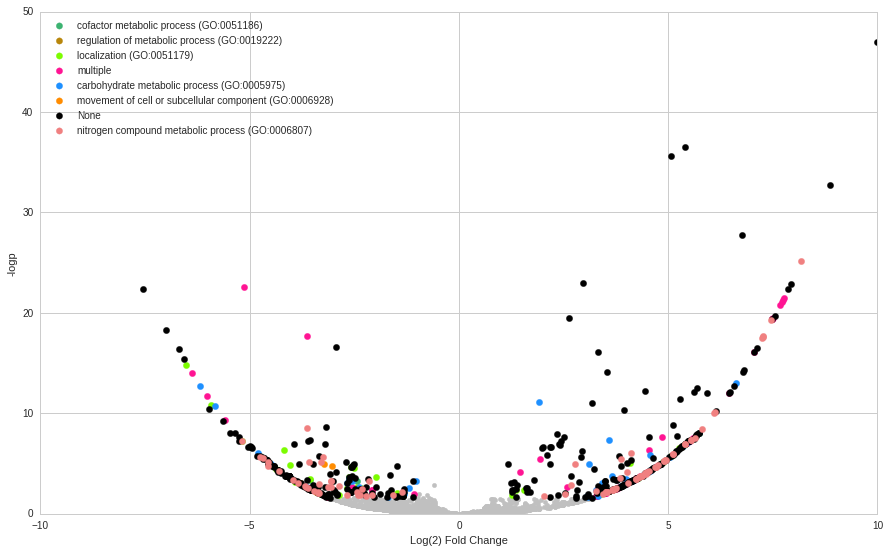

In [135]:
import seaborn as sns
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 9))
fig.set_tight_layout(False)
ax = fig.add_subplot(111)

# Plot the INsig points
X = df_insig['log2FoldChange'].values
Y = df_insig['-logp'].values
ax.scatter(X, Y, color='silver', s=20)

# Plot the sig points
for color in set(df_sig['color']):
    X = df_sig[df_sig.color == color].log2FoldChange
    Y = df_sig[df_sig.color == color]['-logp']
    ax.scatter(X, Y, color=color, s=40, label=group_names[color_group[color]])
    


ax.xaxis.set_label_text("Log(2) Fold Change")
ax.yaxis.set_label_text("-logp")
ax.set_xlim(-10,10)
ax.set_ylim(0,50)
ax.legend(loc=2)